In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller
sns.set_theme(style='darkgrid')

In [2]:
from data import get_price_data
from backtest import backtest_strat
from helpers import resume_backtest, performance_plot, annual_alpha_plot, price_to_perf, correlation, \
                    pred_to_perf, prob_to_pred, prob_to_pred_2
from test import get_training_processed_data
from sklearn.model_selection import train_test_split

In [137]:
indices_price = pd.read_csv('data/prices.csv', index_col=0, parse_dates=True)
indices_price.drop(columns=['SMIMC Index'], inplace=True)
print('Tickers :', list(indices_price.columns))

Tickers : ['SPI Index', 'SMCI Index', 'SPIEX Index', 'SPI20 Index']


In [3]:
price, bench_price, df_X = get_price_data()
daily_returns = price.pct_change().shift(1)

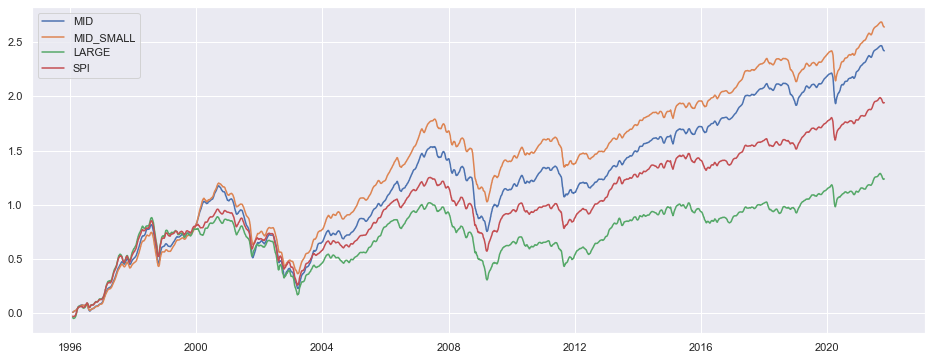

In [5]:
fig, ax = plt.subplots(figsize=(16,6))
best_perf = pred_to_perf(best_pred, daily_returns=daily_returns, log=True)
data_plot = np.log((pd.concat([price, bench_price.rename('SPI')], axis=1).pct_change() + 1).reindex(best_perf.index).cumprod().rolling(20).mean())
sns.lineplot(data=data_plot, dashes=False)
plt.show()

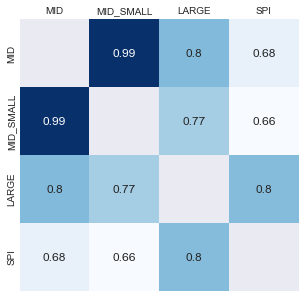

In [32]:
corr = pd.concat([price, bench_price], axis=1).pct_change().resample('W').mean().corr().round(4)

fig, ax = plt.subplots(figsize=(5,5))
mask = np.identity(len(corr))
sns.heatmap(data=corr, annot=True, cmap='Blues', cbar=False, mask=mask, annot_kws=dict(size=12))
ax.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, labeltop=True, length=0)
plt.show()

In [4]:
rebalance_freq = 'W-FRI'
returns = price.pct_change().shift(1).resample(rebalance_freq).agg(lambda x: (x + 1).prod() - 1)
best_pred = returns.rank(axis=1).replace({1: 0., 2: 0., 3: 1.}).shift(-1)

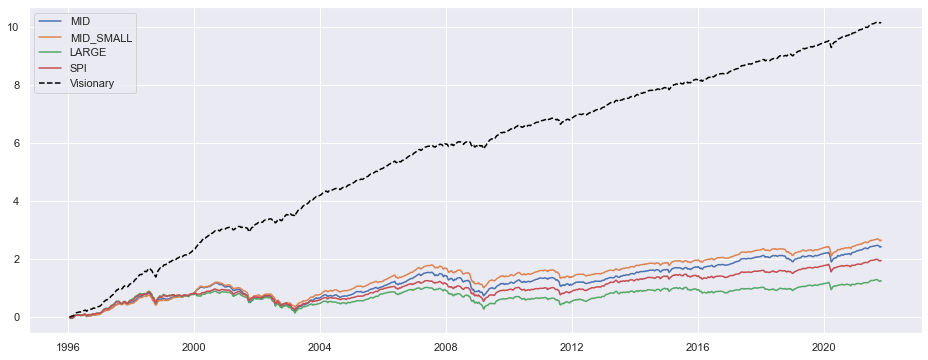

In [6]:
fig, ax = plt.subplots(figsize=(16,6))
best_perf = np.log(pred_to_perf(best_pred, daily_returns=daily_returns).rolling(10).mean())
data_plot = np.log((pd.concat([price, bench_price.rename('SPI')], axis=1).pct_change() + 1).reindex(best_perf.index).cumprod().rolling(10).mean())
sns.lineplot(data=data_plot, dashes=False)
sns.lineplot(data=best_perf, color='black', linestyle='--', label='Visionary')
plt.legend()
plt.show()

In [7]:
data_stats = pd.concat([price, bench_price], axis=1)
data_annual_ret = data_stats.pct_change().mean() * 252 * 100
data_annual_std = data_stats.pct_change().std() * np.sqrt(252) * 100
data_annual_sharpe = data_annual_ret.div(data_annual_std)
data_stats = pd.concat([data_annual_ret, data_annual_std, data_annual_sharpe], axis=1)
data_stats.columns = ['Annualized average return', 'Annualized Std', 'Sharpe Ratio']
data_stats.round(2)

,Annualized average return,Annualized Std,Sharpe Ratio
MID,10.26,15.07,0.68
MID_SMALL,10.89,13.71,0.79
LARGE,6.38,18.16,0.35
SPI,8.81,17.06,0.52


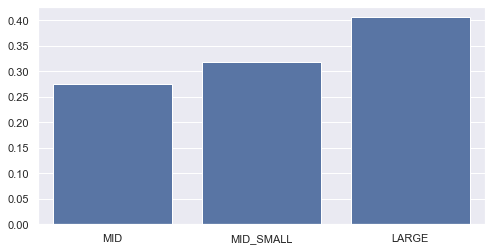

In [8]:
L = len(best_pred)
df_results = (best_pred.sum(axis=0) / L).rename('Best_prediction')
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='index', var_name='strategie', value_name='frequence')

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=df_results, x='index', y='frequence', hue='strategie')
ax.get_legend().remove()
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.show()

### Large cap weekly outperformance appears more frequently than mid or small cap, even though it underperforms in long horizon => we better catch small and mid cap outperformance signals instead of large cap ones

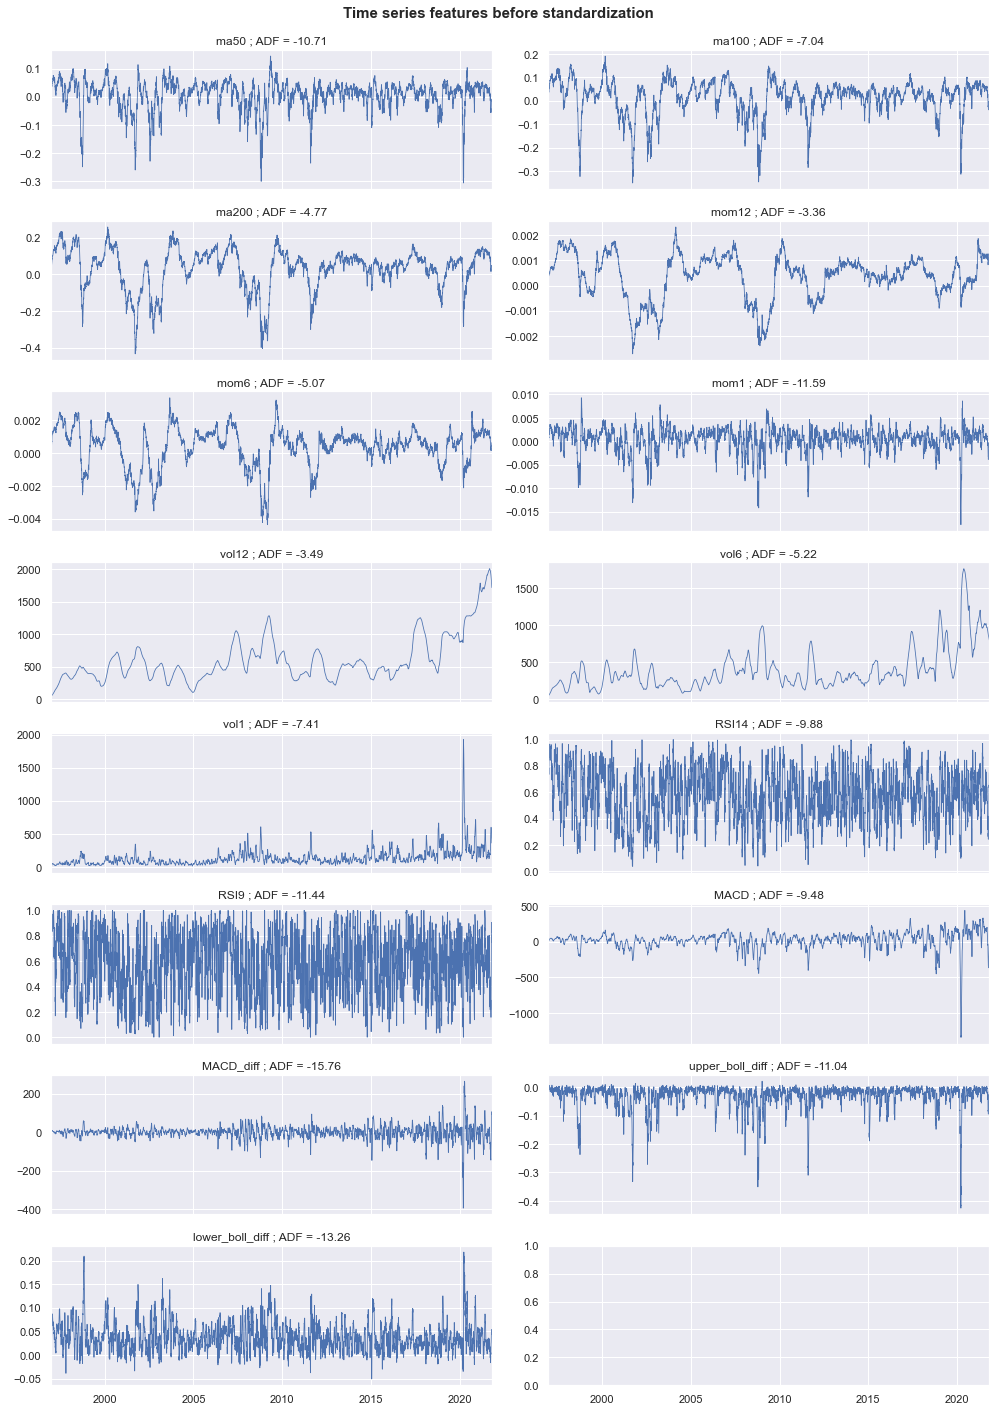

In [9]:
data_plot = df_X.iloc[:, df_X.columns.get_level_values(0) == 'MID']
data_plot.columns = data_plot.columns.get_level_values(1)

number_feature = len(data_plot.columns)
fig, axs = plt.subplots(number_feature // 2 + (number_feature % 2 > 0), 2, figsize=(14, 20), sharex=True)
axs = axs.ravel()
for i, col in enumerate(data_plot.columns):
    results = adfuller(data_plot[col].values)
    data_plot[col].plot(ax=axs[i], lw=0.8)
    axs[i].set_title(col + f' ; ADF = {results[0]:.2f}')
    
plt.suptitle('Time series features before standardization', fontsize=15, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

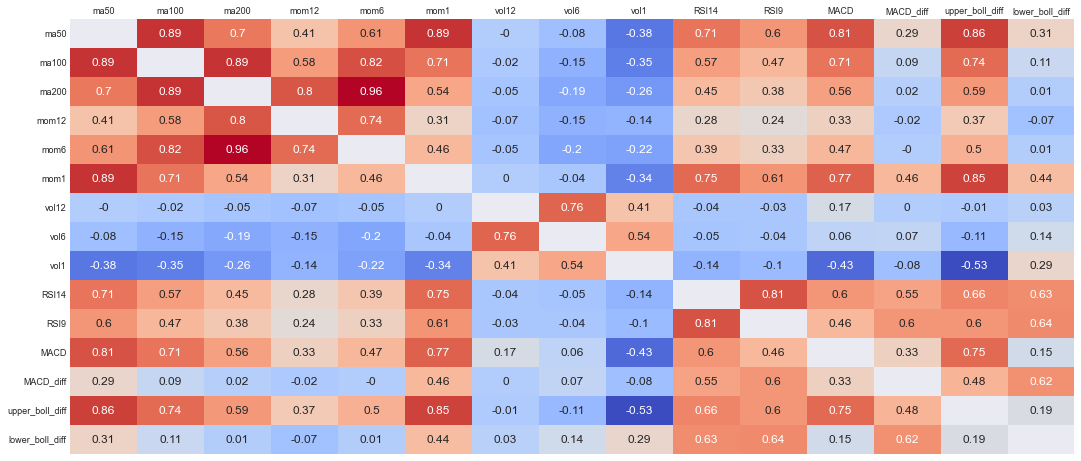

In [10]:
corr = data_plot.corr().round(2)

fig, ax = plt.subplots(figsize=(18,8))
mask = np.identity(len(corr))
sns.heatmap(data=corr, annot=True, cmap='coolwarm', cbar=False, mask=mask, annot_kws=dict(size=12))
ax.tick_params(axis='both', which='major', labelsize=9, labelbottom=False, labeltop=True, length=0)
plt.show()